# Group 5: Synthetic Signal Analysis - with added linear time varying frequency component (kt)

Goal: to obtain a clear estimation of each components by working only with the final signal

* Analyse the final signal: stationary or non-stationary

* Run a FFT analysis to get an idea of the frequency components. Reflect on the results of this analysis

* How to decide the window size if STFT or WT is going to be used?

* Which signal processing technique is best for your signal (FFT, STFT, WVT, WT, HT)? 

* Add an offset and repeat the analysis

* Add white noise and repeat the analysis

* Add a linearly time varying frequency component (frequency=kt)

* Add an offset and white noise and repeat the analysis

Our signal: Components: 5, 48 abd 50 Hz


In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy

## A)

<IPython.core.display.Javascript object>


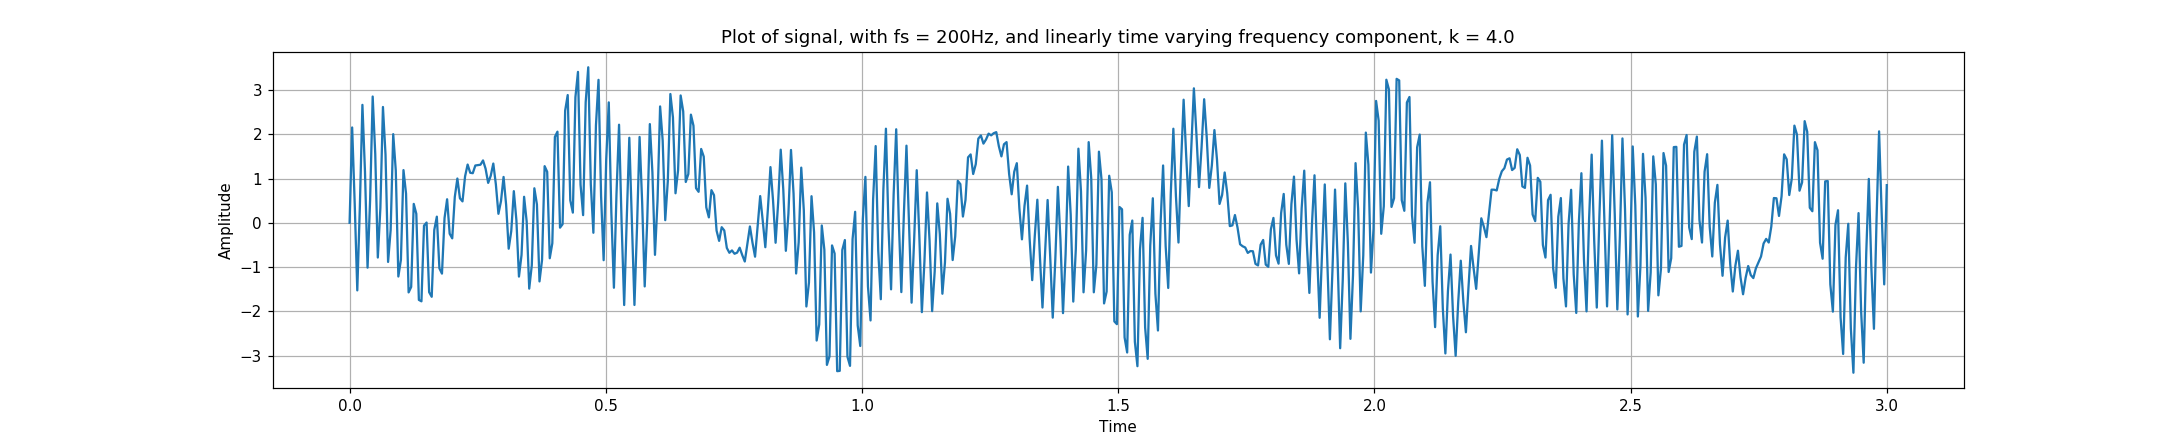

In [5]:
'''
Since the maximum frequency in our signal is 50Hz, then the sampeling 
frequency needs to be bigger than 2*50Hz => over 100Hz
'''
T0 = 3
fs = 200.0
T = 1.0/fs
N = int(T0 / T)



x = np.linspace(0.0, N*T, N)

k = 5.0
ltv = np.sin(k*x*x)
#y = np.sin((5.0 * 2.0*np.pi + k*x)*x) + np.sin((48.0 * 2.0*np.pi + k*x)*x)+ np.sin((50.0 * 2.0*np.pi + k*x)*x)
y = np.sin((5.0 * 2.0*np.pi)*x) + np.sin((48.0 * 2.0*np.pi)*x)+ np.sin((50.0 * 2.0*np.pi)*x) + ltv

plt.figure(figsize=(20, 4))
plt.plot(x, y)
plt.grid()
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title('Plot of signal, with fs = 200Hz, and linearly time varying frequency component, k = 4.0')
plt.draw()

The signal above is stationary, because the frequency components are constant / does not change with time

## B)

<IPython.core.display.Javascript object>


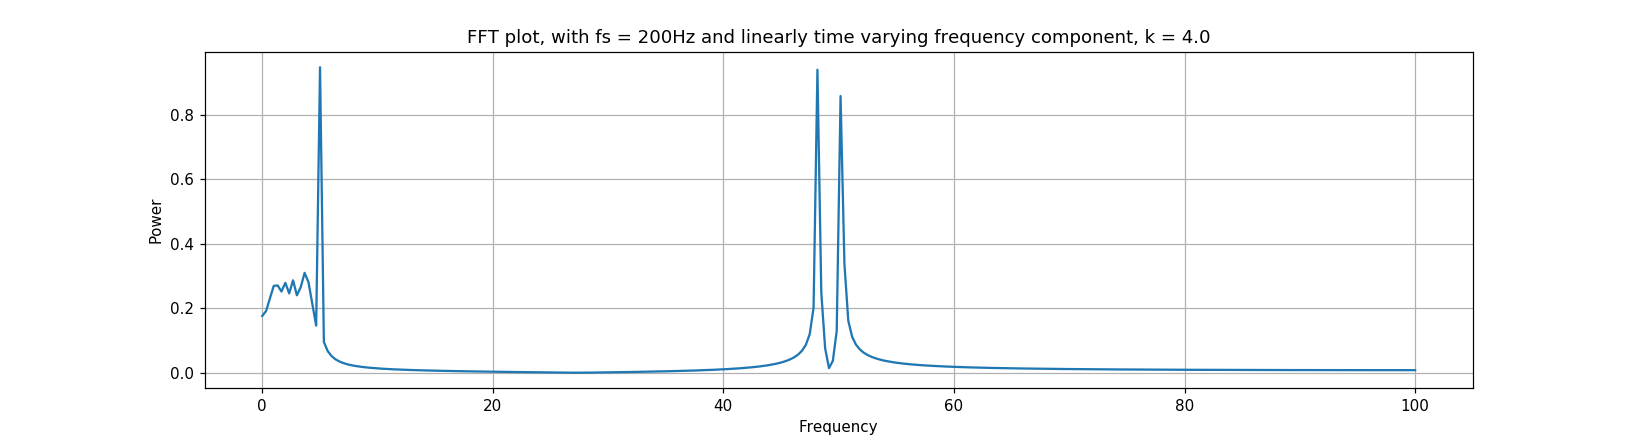

In [6]:
from scipy.fft import fft

yf = fft(y)

xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

plt.figure(figsize=(15, 4))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.ylabel('Power')
plt.xlabel('Frequency')
plt.title('FFT plot, with fs = 200Hz and linearly time varying frequency component, k = 4.0')

plt.show()

We have three prominent peaks at three frequencies 5, 48, 50 Hz. However due to the noise, jitter has been introduced to some frequencies

In [8]:
window = 1/50
print(f'The window length needs to be at least {round(window,4)} seconds')
nseg = T0 / window
print(f'The number of segments to be used should be at least {int(nseg)}')


The window length needs to be at least 0.02 seconds
The number of segments to be used should be at least 150


## C)

#### STFT

<IPython.core.display.Javascript object>


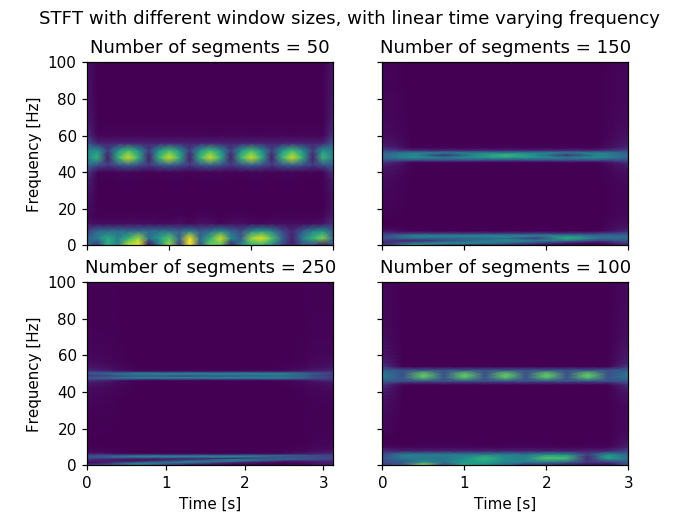

Text(0.5, 0.98, 'STFT with different window sizes, with linear time varying frequency')

In [9]:
from scipy.signal import stft
res = []
for i in range(3):
    f, t, Zxx = stft(y, fs, nperseg=nseg + (i - 1)* 100)
    res.append([f, t, Zxx])
    
f, t, Zxx = stft(y, fs, nperseg=100)
res.append([f, t, Zxx])


fig, axs = plt.subplots(2, 2)

axs[0, 0].pcolormesh(res[0][1], res[0][0], np.abs(res[0][2]), vmin=0, vmax=1, shading='gouraud')
axs[0, 0].set_title('Number of segments = 50')
axs[0, 1].pcolormesh(res[1][1], res[1][0], np.abs(res[1][2]), vmin=0, vmax=1, shading='gouraud')
axs[0, 1].set_title('Number of segments = 150')
axs[1, 0].pcolormesh(res[2][1], res[2][0], np.abs(res[2][2]), vmin=0, vmax=1, shading='gouraud')
axs[1, 0].set_title('Number of segments = 250')
axs[1, 1].pcolormesh(res[3][1], res[3][0], np.abs(res[3][2]), vmin=0, vmax=1, shading='gouraud')
axs[1, 1].set_title('Number of segments = 100')

for ax in axs.flat:
    ax.set(xlabel='Time [s]', ylabel='Frequency [Hz]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
plt.suptitle('STFT with different window sizes, with linear time varying frequency')

#### Using WVD (Wigner-Ville Distribution)

https://tftb.readthedocs.io/en/latest/auto_examples/plot_4_1_3_chirps_wvd.html

<IPython.core.display.Javascript object>


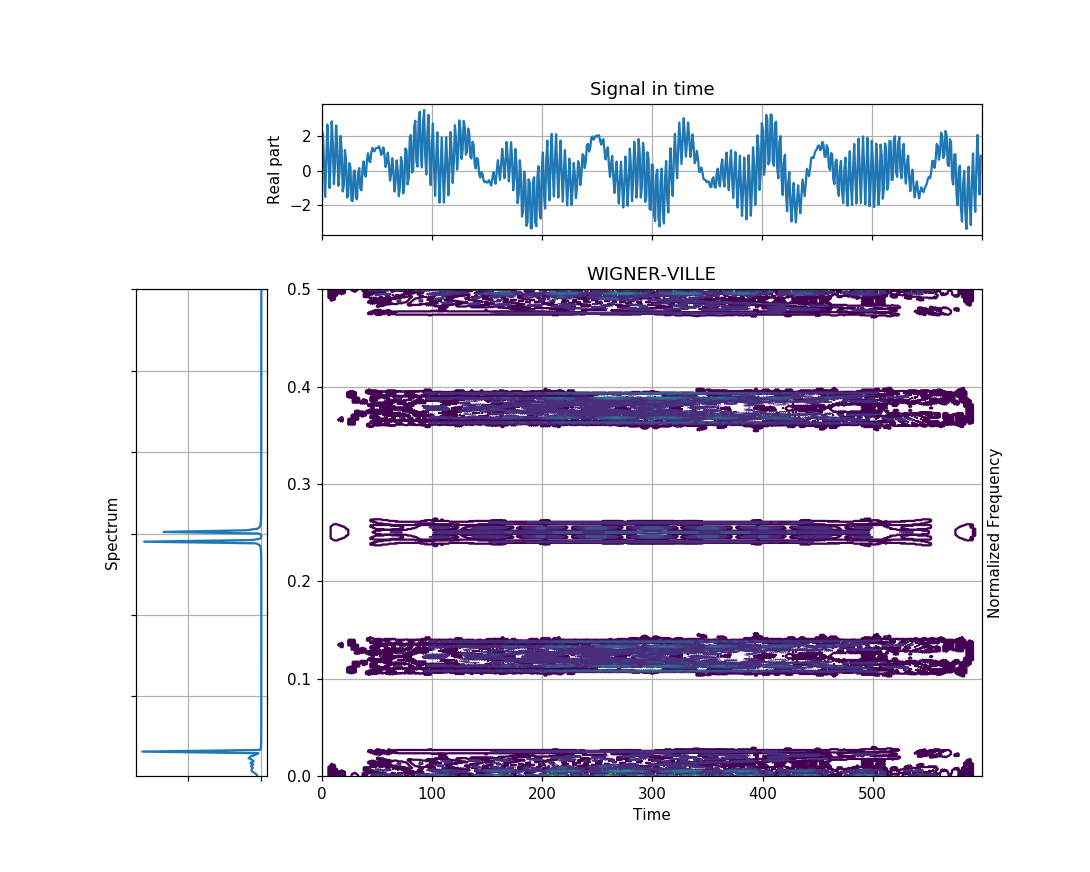

In [10]:
from tftb.generators import fmlin, amgauss
from tftb.processing import WignerVilleDistribution


tfr = WignerVilleDistribution(y)
tfr.run()
tfr.plot(kind='contour',show_tf=True)

#### Using WT (Wavelet Transform)

Is suitable for analysing irregular data patterns, such as non-stationary signals

<IPython.core.display.Javascript object>


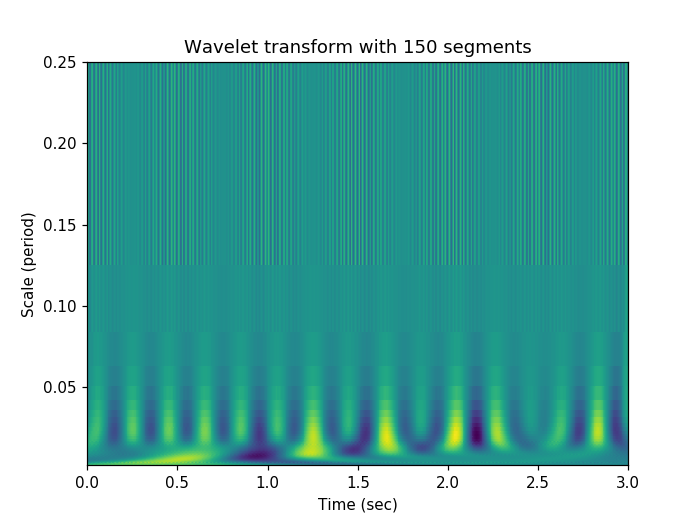

Text(0.5, 1.0, 'Wavelet transform with 150 segments')

In [11]:
import pywt

plt.figure()
# scales = np.arange(1, 51)
scales = np.arange(1, nseg)
cwtmatr, freqs = pywt.cwt(y, scales, 'mexh')
plt.pcolor(x, freqs, cwtmatr)

# plt.ylim([1, 100])
plt.ylabel('Scale (period)')
plt.xlabel('Time (sec)')
plt.title('Wavelet transform with 150 segments')

#### Hilbert Transform

Used on MONO-signals. In our case we have multiple frequencies in the signal, hence HT will not work, unless we transform the signal into one frequency component. 

<IPython.core.display.Javascript object>


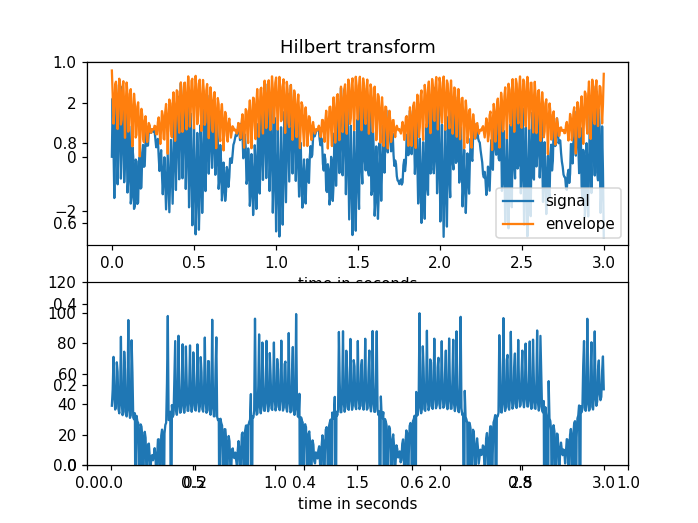

(0.0, 120.0)

In [9]:
from scipy.signal import hilbert

analytic_signal = hilbert(y)

amplitude_envelope = np.abs(analytic_signal)

instantaneous_phase = np.unwrap(np.angle(analytic_signal))

instantaneous_frequency = (np.diff(instantaneous_phase) /

                           (2.0*np.pi) * fs)

fig = plt.figure()
plt.title('Hilbert transform')
ax0 = fig.add_subplot(211)

ax0.plot(x, y, label='signal')

ax0.plot(x, amplitude_envelope, label='envelope')

ax0.set_xlabel("time in seconds")

ax0.legend()

ax1 = fig.add_subplot(212)

ax1.plot(x[1:], instantaneous_frequency)

ax1.set_xlabel("time in seconds")

ax1.set_ylim(0.0, 120.0)